# 6.4 Preprocess department 24-00098 (St. Paul, MN)


This is another department that I haven't looked at yet. The type of data is *vehicle stops* (only department).

I think that the variables of interest here might be others (location may not matter much if drivers do not represent the local population). However, I will process things the same, to preserve integrity.

In [68]:
import functools

import geopandas
import matplotlib.pyplot
import numpy
import pandas
import shapely

from cpe_help import Department, util

In [2]:
dept = Department('24-00098')
path = dept.tabular_input_dir / '24-00098_Vehicle-Stops-data.csv'
df = pandas.read_csv(path, low_memory=False, skiprows=[1])

In [3]:
df.shape

# 710k entries!

(710472, 12)

In [4]:
df.tail().T

,710467,710468,710469,710470,710471
INCIDENT_DATE_YEAR,2017,2017,2017,2017,2017
INCIDENT_DATE,12/31/17 22:14,12/31/17 22:35,12/31/17 23:02,12/31/17 23:08,12/31/17 23:16
SUBJECT_RACE,Black,White,Asian,Black,Asian
SUBJECT_GENDER,Female,Male,Male,Male,Male
SEARCH_CONDUCTED_PERSON,No,No,No,No,No
SEARCH_CONDUCTED_VEHICLE,No,No,No,No,No
SUBJECT_ISSUED_CITATION,No,No,No,No,No
SUBJECT_AGE,NaN,NaN,NaN,NaN,NaN
INCIDENT_REASON,Moving Violation,Moving Violation,Moving Violation,Moving Violation,Moving Violation
LOCATION_DISTRICT,32,130,230,74,34


The data looks simple and clean. I believe this will be a quick job.

# Date

Date and time are present in the INCIDENT_DATE column. If there's any ambiguity in the year, we can solve it with the INCIDENT_DATE_YEAR columns (probably not needed).

In [5]:
date = df['INCIDENT_DATE']
datef = pandas.to_datetime(date, format='%m/%d/%y %H:%M')

In [6]:
datef.describe()

count                  710472
unique                 665520
top       2001-08-22 19:29:00
freq                       28
first     2001-01-01 00:11:00
last      2017-12-31 23:16:00
Name: INCIDENT_DATE, dtype: object

I like how the date goes from 2001 to 2017 and that the top date is not something clear.

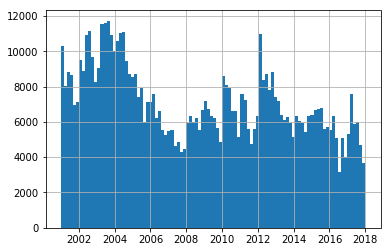

In [7]:
datef.hist(bins=100)

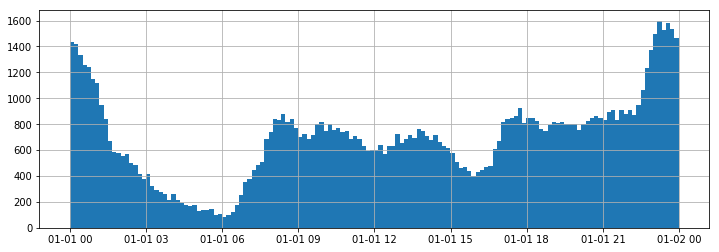

In [8]:
times = datef.copy().sample(100000)
times = times.apply(lambda x: x.replace(year=2010, month=1, day=1))
times.hist(bins=144, figsize=(12, 4))

I really like this smooth curve.

Something that just came to my mind... **Are entries all UTC?** Or do I need to convert the times to the location timezone? This is probably hard to answer and requires collaboration from the poilice departments or deep research.

# Geography

In [9]:
dept.load_external_shapefile().crs

{'init': 'epsg:4326'}

We will use WGS84 as expected.

In [10]:
lat = df['LOCATION_LATITUDE']
lon = df['LOCATION_LONGITUDE']

In [11]:
lat.isnull().mean()

0.0009951131079057303

In [12]:
lon.isnull().mean()

0.0009951131079057303

In [13]:
(lat.isnull() == lon.isnull()).all()

True

In [14]:
(lat == 0).any()

False

In [15]:
(lon == 0).any()

False

In [16]:
Point = shapely.geometry.Point

points = [Point(lon, lat) if not numpy.isnan(lon) else Point()
          for lat, lon in zip(df['LOCATION_LATITUDE'], df['LOCATION_LONGITUDE'])]
crs = util.crs.epsg4326
geocoded = df['LOCATION_LATITUDE'].notnull()

new_df = geopandas.GeoDataFrame(
    df,
    geometry=points,
    crs=crs,
)
new_df['geocoded'] = geocoded

In [17]:
new_df['geocoded'].mean()

0.9990048868920943

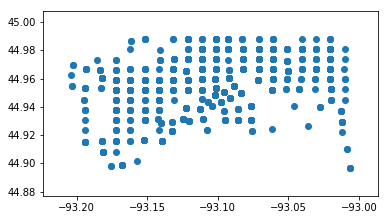

In [18]:
new_df.sample(1000).plot()

What the actual fuck! The points are quantized, lol!

Never seen anything like that in my life before. Hmmm, we need to know that quantization areas, or are they just the center for police precincts?

In [19]:
precincts = dept.load_police_precincts()

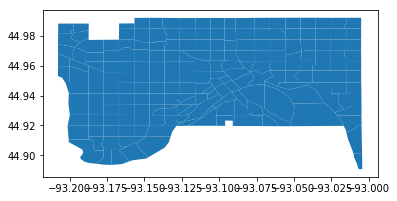

In [20]:
precincts.plot()

We need to overlay.

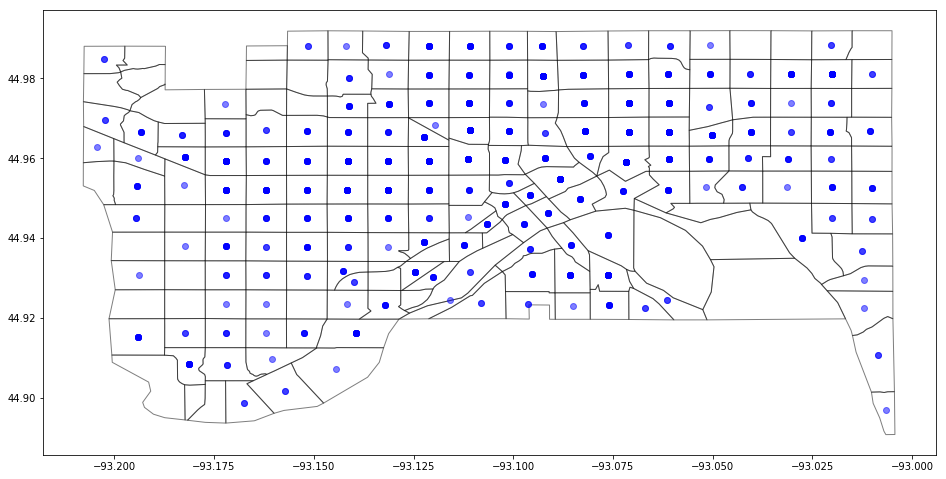

In [21]:
fig, ax = matplotlib.pyplot.subplots(figsize=(16, 12))

ax.set_aspect('equal')

precincts.plot(ax=ax, facecolor='none', edgecolor=(0, 0, 0, 0.5))
new_df.sample(1000).plot(ax=ax, color='blue', alpha=0.5)

I may be dreaming, but these points could be centroids to the bounding boxes.

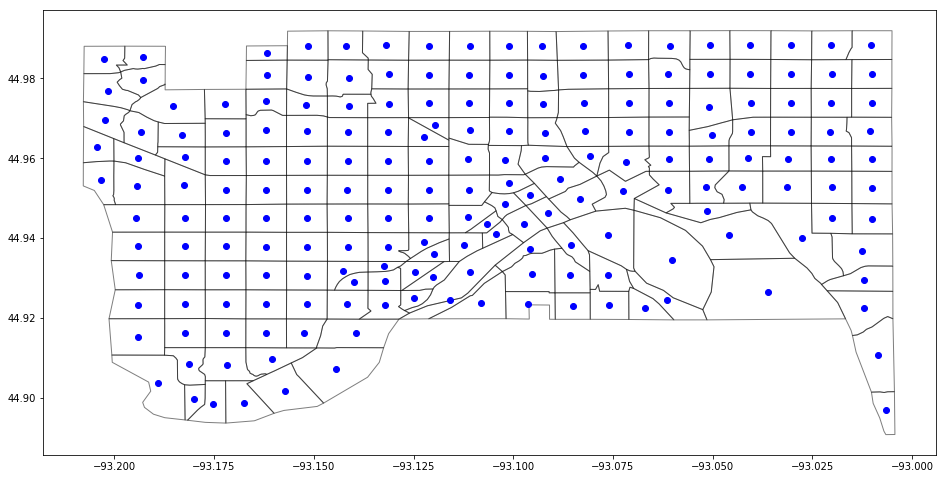

In [23]:
fig, ax = matplotlib.pyplot.subplots(figsize=(16, 12))

ax.set_aspect('equal')

precincts.plot(ax=ax, facecolor='none', edgecolor=(0, 0, 0, 0.5))
precincts.centroid.plot(ax=ax, color='blue')

Or just, you know, the usual centroids :)

Good news is we can use these locations to determine the exact police precinct associated with this traffic stop. Bad news is that we don't have the exact location of the stops (but, these wouldn't be useful anyway, right?).

# Precinct

I'm gonna convert the `LOCATION_*` variables into a `LOCATION_DISTRICT`.

The district in this case will be referring to the grid number of each precinct (there's an explanation in [the report][1])

[1]: https://www.stpaul.gov/sites/default/files/Media%20Root/Police/2016CrimeReport.pdf

In [26]:
precincts = dept.load_police_precincts()
precincts.head()

,dist,gridnum,TOTAL_POPULATION,SEX_TOTAL,SEX_MALE,SEX_FEMALE,RACE_TOTAL,RACE_NH_WHITE,RACE_NH_BLACK,RACE_NH_INDIAN,...,RACE_NH_OTHER,RACE_NH_MULTIRACIAL,RACE_HISPANIC,POVERTY_TOTAL,POVERTY_BPL,POVERTY_NOT_BPL,EMPLOYMENT_TOTAL,EMPLOYMENT_EMPLOYED,EMPLOYMENT_UNEMPLOYED,geometry
0,Western District,82,663.013465,663.013465,316.589700,346.423765,663.013465,424.388210,166.617826,0.020766,...,0.001332,18.924935,10.077782,662.575312,99.621044,562.954268,466.620546,456.808720,9.811825,POLYGON ((-93.18731873325051 44.95984522374139...
1,Western District,62,301.564696,301.564696,154.984476,146.580220,301.564696,185.489457,38.144874,0.000000,...,4.868299,14.909324,5.623478,301.564696,92.211244,209.353452,220.404857,200.056695,20.348162,"POLYGON ((-93.1891517284332 44.96150365239401,..."
2,Western District,43,993.322664,993.322664,529.228454,464.094210,993.322664,623.488030,85.079395,13.373254,...,5.815563,47.429400,20.752123,955.172856,220.810402,734.362454,695.011908,647.200873,47.811035,POLYGON ((-93.18726521154463 44.97865486589834...
3,Western District,22,1346.906929,1346.906929,720.885604,626.021325,1346.906929,951.340966,50.002646,5.678168,...,0.000000,16.728875,49.174432,1186.076090,273.797793,912.278298,788.844741,752.456147,36.388594,POLYGON ((-93.18723966266045 44.98348311651917...
4,Western District,63,863.340737,863.340737,417.973022,445.367714,863.340737,627.118312,46.340809,5.334480,...,2.635689,124.635566,22.845674,863.340737,116.748810,746.591927,616.242406,576.345241,39.897165,POLYGON ((-93.18741336776411 44.96870629898084...


In [29]:
precincts.shape

(200, 22)

In [30]:
precincts.gridnum.nunique()

200

In [63]:
lats = df['LOCATION_LATITUDE']
lons = df['LOCATION_LONGITUDE']
centroids = precincts.set_index('gridnum').centroid

In [64]:
points = list(zip(lats, lons))

In [66]:
len(points)

710472

In [65]:
# we can use this to optimize the process
len(set(points))

1107

In [78]:
%%time

@functools.lru_cache(maxsize=1500)
def get_gridnum(lat, lon):
    point = Point(lon, lat)
    distances = centroids.distance(point)
    # lat/lon isn't the best way of comparing distances,
    # however, this will be enough, given that the inupt points
    # are so close to the targets
    return distances.idxmin()

gridnums = [get_gridnum(lat, lon) for lat, lon in points]

CPU times: user 2.21 s, sys: 3.35 ms, total: 2.21 s
Wall time: 2.22 s


In [79]:
gridnums[:5]

['55', '106', '58', '44', '95']